# Part 1 of the SOD314 Project

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cp
from scipy.optimize import minimize
np.random.seed(3)

## Utility functions

In [2]:
def k(x,y):
  # Returns the result of Euclidiean kernel k(x,y) 
  return np.exp(-np.linalg.norm(x-y)**2)

def compute_K(X,Y):
    # Computes the matrix K = (k(x,y))
    return np.array([[k(Xi,Yj) for Yj in Y] for Xi in X])

def plot_f(alpha,x_selected,x):
    # Returns the evaluation of the function f defined by alpha at points x
    K = compute_K(x,x_selected)
    return K@alpha

In [3]:
with open('../databases/first_database.pkl', 'rb') as f:
    x,y = pkl.load(f)

## Plot the dataset

Text(0, 0.5, 'y')

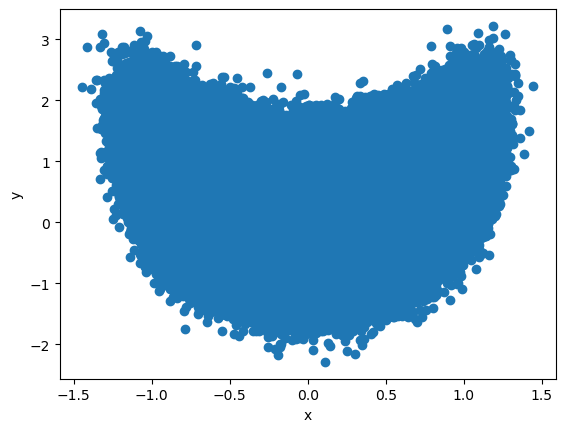

In [4]:
plt.plot(x,y,'o')
plt.xlabel("x")
plt.ylabel("y")

## Parameters of the problem

In [5]:
n = 100
m = 10
a = 5
sigma = 0.5

M = np.random.choice(np.array(range(n)),size=m, replace=False)

x_selected = x[M]
y_selected = y[M]

#agents = [M[2*i:2*i+2] for i in range(a)]
#agents = np.array([np.arange(20*i,20*i+20) for i in range(a)])
agents = np.array_split(np.random.choice(np.array(range(n)),size=n, replace=False),a)

Text(0, 0.5, 'y')

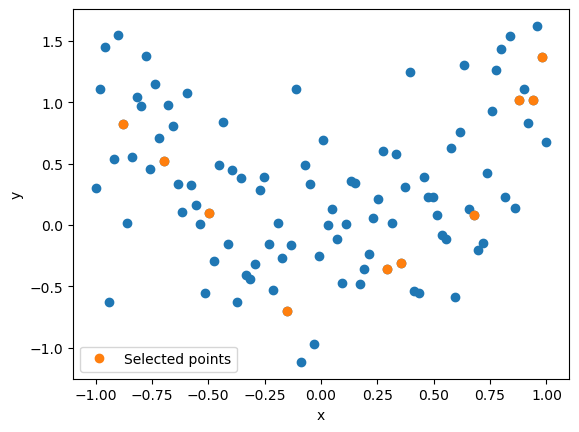

In [6]:
plt.plot(x[:n],y[:n],'o')
plt.plot(x_selected,y_selected,'o',label="Selected points")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

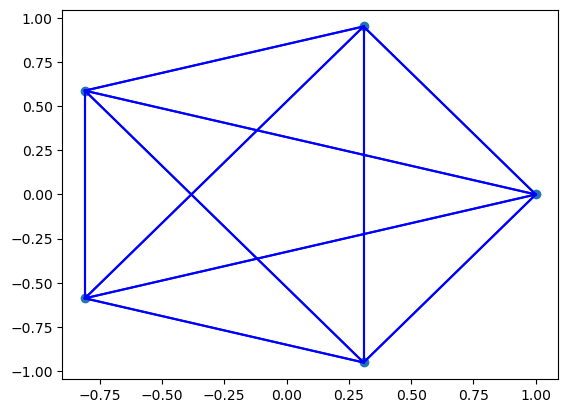

In [7]:
#W = np.ones((a,a))/(a-1) - np.eye(a)/(a-1)
W = np.ones((a,a))/a
agent_x = np.zeros(a)
agent_y = np.zeros(a)

for i in range(a):
  agent_x[i] = np.cos(2*np.pi*i/a)
  agent_y[i] = np.sin(2*np.pi*i/a)

plt.scatter(agent_x,agent_y)

for i in range(a):
  for j in range(a):
    if W[i,j] != 0:
      plt.plot([agent_x[i],agent_x[j]],[agent_y[i],agent_y[j]],c="blue")

## Find the true $\alpha^\star$ using CVX 

In [8]:
def objectif(alpha):
    return cp.pnorm(y[:n] - K_nm@alpha,p=2)**2/(2*sigma**2) + 0.5*cp.quad_form(alpha, K_mm)

In [9]:
# Construct the problem.
K_mm = compute_K(x_selected,x_selected)
K_nm = compute_K(x[:n],x_selected)
true_alpha = cp.Variable(m)
objective = cp.Minimize(objectif(true_alpha))
prob = cp.Problem(objective)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(true_alpha.value)
true_alpha = true_alpha.value

[ 14.5282715    1.58049358  -5.35396136   2.56261574  -9.94101134
 -11.71695081   4.63345581   2.72738754 -15.50431343  18.04274968]


Text(0.5, 1.0, 'Plot of $f$ using CVX to solve the problem')

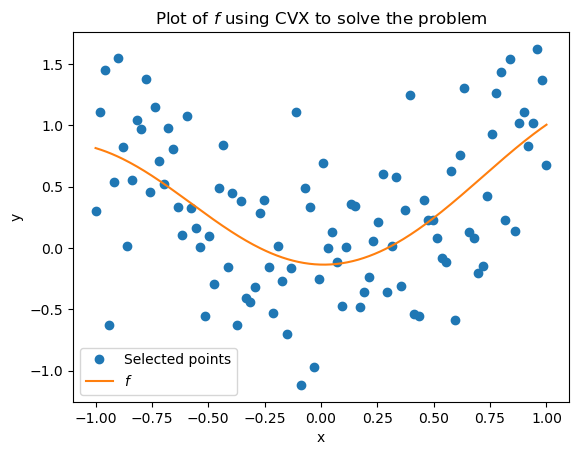

In [10]:
s = 250
x_prime = np.linspace(-1,1,s)
f_approx_true_cvx = plot_f(true_alpha,x_selected,x_prime)
plt.plot(x[:n],y[:n],'o',label="Selected points")
plt.plot(x_prime,f_approx_true_cvx, label= "$f$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Plot of $f$ using CVX to solve the problem")

## Find the true $\alpha^\star$ using linear algebra

We have 
$$\alpha^\star = \arg\min_{\alpha \in \mathbb{R}^m} \underbrace{\frac{1}{2}\alpha^T K_{mm}\alpha + \frac{1}{2\sigma^2}\|y - K_{nm}\alpha\|^2_2}_{:= g(\alpha)}  $$
Let us denote 
$$g \colon \alpha \mapsto \frac{1}{2}\alpha^T K_{mm}\alpha + \frac{1}{2\sigma^2}\|y - K_{nm}\alpha\|^2_2$$
Then, $g$ is differentiable and one has :
$$\nabla g(\alpha) = K_{mm}\alpha - \frac{1}{\sigma^2}K_{nm}^T(y - K_{nm}\alpha)$$
So,
$$\nabla g(\alpha) = 0 \iff \left[K_{mm} + \frac{1}{\sigma^2}K_{nm}^TK_{nm}\right]\alpha = \frac{1}{\sigma^2}K_{nm}^Ty \iff \alpha = \frac{1}{\sigma^2}\left[K_{mm} + \frac{1}{\sigma^2}K_{nm}^TK_{nm}\right]^{-1}K_{nm}^Ty$$
The question is : is $K_{mm} + \frac{1}{\sigma^2}K_{nm}^TK_{nm}$ invertible ? This matrix is symmetric and positive semidefinite. Manifestement oui !

In [11]:
np.linalg.det(K_mm + K_nm.T@K_nm/(sigma**2))

5.062045824583027e-25

In [12]:
true_alpha_linalg = np.linalg.solve((sigma**2)*K_mm + K_nm.T@K_nm,K_nm.T@y[:n])

In [13]:
true_alpha_linalg

array([ 73.03022309,  27.4543655 ,  -5.53588133, -18.97749538,
       -93.88850914, -28.28334159,  41.23131159,   4.42176363,
       -16.67906655,  18.78570694])

Text(0.5, 1.0, 'Plot of $f$ using linear algebra to solve the problem \n Error between both = 5.260286554307624e-05')

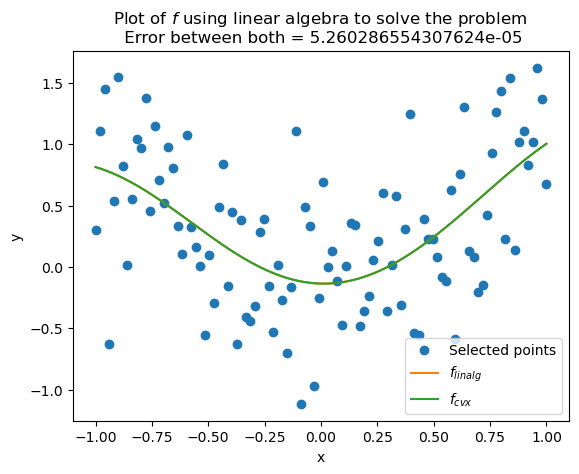

In [14]:
s = 250
x_prime = np.linspace(-1,1,s)
f_approx_true_linalg = plot_f(true_alpha_linalg,x_selected,x_prime)
plt.plot(x[:n],y[:n],'o',label="Selected points")
plt.plot(x_prime,f_approx_true_linalg, label= "$f_{linalg}$")
plt.plot(x_prime,f_approx_true_cvx, label= "$f_{cvx}$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Plot of $f$ using linear algebra to solve the problem \n Error between both = " + str(np.linalg.norm(f_approx_true_linalg-f_approx_true_cvx)))

In [15]:
def g(alpha,K,M,Y,n,sigma):
    K_mm = K[M,:][:,M]
    K_nm = K[:n][:,M]
    return alpha.T@K_mm@alpha/2 +  np.linalg.norm(Y[:n] - K_nm@alpha,ord=2)**2/(2*sigma**2)

In [16]:
K = compute_K(x[:n],x[:n])
g(true_alpha,K,M,y,n,sigma)

52.493583372648445

In [17]:
K = compute_K(x[:n],x[:n])
g(true_alpha_linalg,K,M,y,n,sigma)

52.49358146102121

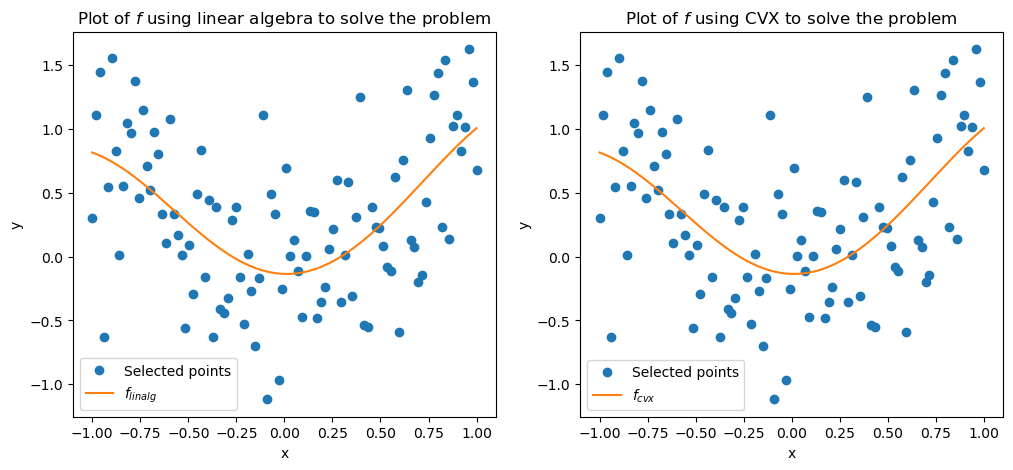

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x[:n],y[:n],'o',label="Selected points")
plt.plot(x_prime,f_approx_true_linalg, label= "$f_{linalg}$")
#plt.plot(x_prime,f_approx_true_cvx, label= "$f_{cvx}$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Plot of $f$ using linear algebra to solve the problem")
plt.subplot(1,2,2)
plt.plot(x[:n],y[:n],'o',label="Selected points")
#plt.plot(x_prime,f_approx_true_linalg, label= "$f_{linalg}$")
plt.plot(x_prime,f_approx_true_cvx, label= "$f_{cvx}$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Plot of $f$ using CVX to solve the problem")

plt.savefig("../figures/plot_f_both_technics.pdf")


## Study of the $g_a$

The problem we want to solve in this part is 
$$\alpha^\star = \arg\min_{\alpha \in \mathbb{R}^m} \sum_{a=1}^5 \frac{1}{5}\frac{1}{2}\alpha^T K_{mm}\alpha + \frac{1}{2\sigma^2}\sum_{i\in A}\|y_i - K_{(i)m}\alpha\|^2_2$$

Let us then define, for $a \in \{1,...,5\}$,
$$g_a \colon \alpha \mapsto \frac{1}{5}\frac{1}{2}\alpha^T K_{mm}\alpha + \frac{1}{2\sigma^2}\sum_{i\in A}\|y_i - K_{(i)m}\alpha\|^2_2$$
Therefore, the problem is now : $\alpha^\star = \arg\min_{\alpha \in \mathbb{R}^m} \sum_{a=1}^5 g_a(\alpha)$. To correctly choose the parameters for the Decentralized Gradient Descent (DGD) algorithm, we need to study the smoothness of the $g_a$. 

- First of all, the $g_a$ are convex functions as the sum of convex functions.
- We need to find $L_a$ such that $g_a$ is $L_a$-smooth. For this, let us look at the Hessian matrix $\nabla^2 g_a(\alpha)$ of $g_a$ : 
$$\nabla^2 g_a(\alpha) = \frac{1}{5}K_{mm} + \frac{1}{\sigma^2}\sum_{i\in A} K_{(i)m}K_{(i)m}^T$$
We want $L_a$ to be such that $0 \preccurlyeq \nabla^2 g_a(\alpha) \preccurlyeq L_a I_m$. To find $L_a$ we are going to look at the eigenvalues of $\nabla^2 g_a(\alpha)$. We need to choose $L_a$ such that all eigenvalues of $\nabla^2 g_a(\alpha)$ are smaller than $L_a$.
Then, we choose $L = \max_{a} L_a$. 

In [19]:
m_a = np.zeros(a)
L_a = np.zeros(a)
K = compute_K(x[:n],x[:n])
K_mm = K[M,:][:,M]
for j in range(a):
    # We look at the eigenvalues of each \nabla^2 g_a
    nabla_g_a = K_mm/5 
    for i in agents[j]:
        K_im = K[i,:][M]
        nabla_g_a += K_im@K_im.T/(sigma**2)
    
    eigenval, eigenvec = np.linalg.eig(nabla_g_a)
    L_a[j] = np.max(np.abs(eigenval))
    m_a[j] = np.min(np.abs(eigenval))
L = np.max(L_a)
m = np.min(m_a)
print("L = " + str(L))
print("m = " + str(m))

L = 3954.622276138397
m = 5.814031033731711e-11


## Decentralized Gradient Descent

In [20]:
def nabla_g_a(alpha,a,sigma,y,K,M,agents):
    K_mm = K[M,:][:,M]
    
    somme = np.zeros(len(alpha))
    for i in agents[a]:
        K_im = K[i,:][M]
        somme += (y[i] - K_im@alpha)*K_im.T
        
    return K_mm@alpha/5  - somme/(sigma**2)

In [33]:
def DGD(nb_it,agents,M,W,K,Y,step_size,sigma,alpha_star):
    nb_agents = len(agents) # Number of agents at play
    m = len(M)
    error = np.zeros((nb_it,nb_agents))
    # We start by initializing the alpha at each devices : alpha_O^i = 0
    # as suggested in the paper "On the Convergence of Decentralized Gradient Descent", Yuan et al. (Theorem 1)
    y = np.zeros((nb_agents,m))
    g_val = np.zeros(nb_it)
    for k in tqdm(range(nb_it)):
        # We update y
        new_y = y.copy()
        
        # Mixing
        mixing = W@y
        
        # Update 
        for a in range(nb_agents):
            grad = nabla_g_a(y[a],a,sigma,Y,K,M,agents)
            new_y[a] = mixing[a] - step_size*grad
    
        y = new_y.copy()
        error[k] = np.linalg.norm(y - alpha_star,axis=1)
        g_val[k] = g(np.mean(y,axis=0),K,M,Y,n,sigma)
        
    return y, error, g_val


In [42]:
def DGD_2(nb_it,agents,M,W,K,Y,step_size,sigma,alpha_star):
    nb_agents = len(agents) # Number of agents at play
    m = len(M)
    error = []
    # We start by initializing the alpha at each devices : alpha_O^i = 0
    # as suggested in the paper "On the Convergence of Decentralized Gradient Descent", Yuan et al. (Theorem 1)
    y = np.zeros((nb_agents,m))
    g_val = g(np.mean(y,axis=0),K,M,Y,n,sigma)
    g_vals = [g_val]
    k = 0
    #for k in tqdm(range(nb_it)):
    while (np.abs(g_val - g(alpha_star,K,M,Y,n,sigma)) > step_size):
        # We update y
        new_y = y.copy()
        
        # Mixing
        mixing = W@y
        
        # Update 
        for a in range(nb_agents):
            grad = nabla_g_a(y[a],a,sigma,Y,K,M,agents)
            new_y[a] = mixing[a] - step_size*grad
    
        y = new_y.copy()
        error.append(np.linalg.norm(y - alpha_star,axis=1))
        g_val = g(np.mean(y,axis=0),K,M,Y,n,sigma)
        g_vals.append(g_val)
        k += 1
        if k%10000 == 0:
            print(g_val)
    return y, error, g_vals


In [ ]:
K = compute_K(x[:n],x[:n])
step_size = 2/L
res,error,g_val = DGD_2(nb_it,agents,M,W,K,y[:n],step_size,sigma,true_alpha_linalg)

In [1]:
nb_it = 30000
K = compute_K(x[:n],x[:n])
step_size = 1/L
res,error,g_val = DGD(nb_it,agents,M,W,K,y[:n],step_size,sigma,true_alpha_linalg)

NameError: name 'compute_K' is not defined

In [25]:
alpha = np.mean(res,axis=0)

In [26]:
alpha

array([ 0.4533836 , -0.4737431 ,  0.87134379, -0.54153316,  0.57430011,
        0.04889306,  0.652803  , -0.61037615, -0.05748641,  0.43641304])

In [27]:
g(alpha,K,M,y,n,sigma)

52.76702893105565

Text(0.5, 1.0, 'Evolution of the value of $g(\\overline{\\alpha}_t)$ as the number of iterations grows')

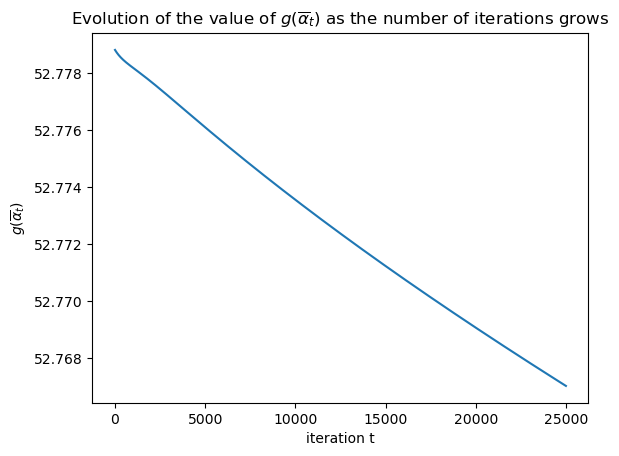

In [32]:
plt.loglog(g_val)
plt.xlabel("iteration t")
plt.ylabel("$g(\\overline{\\alpha}_t)$")
plt.title("Evolution of the value of $g(\\overline{\\alpha}_t)$ as the number of iterations grows")

#### Plot of the obtained function

Text(0.5, 1.0, 'Plot of $f$ using DGD to solve the problem \n Error between both = 0.47855778016985284')

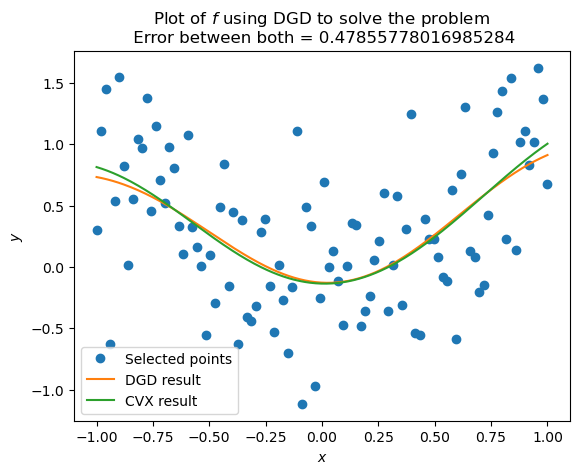

In [27]:
f_approx = plot_f(alpha,x_selected,x_prime)
plt.plot(x[:n],y[:n],'o',label="Selected points")
plt.plot(x_prime,f_approx,label="DGD result")
plt.plot(x_prime,f_approx_true_linalg,label="CVX result")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Plot of $f$ using DGD to solve the problem \n Error between both = " +str(np.linalg.norm(f_approx-f_approx_true_linalg)))

#### Plot of the  optimality gap $\|\alpha_t^i - \alpha^\star\|$

Text(0.5, 1.0, 'Plot of the optimality gap $\\|\\|\\alpha_t^i - \\alpha^*\\|\\|$ \n as a function of the number of iteration t')

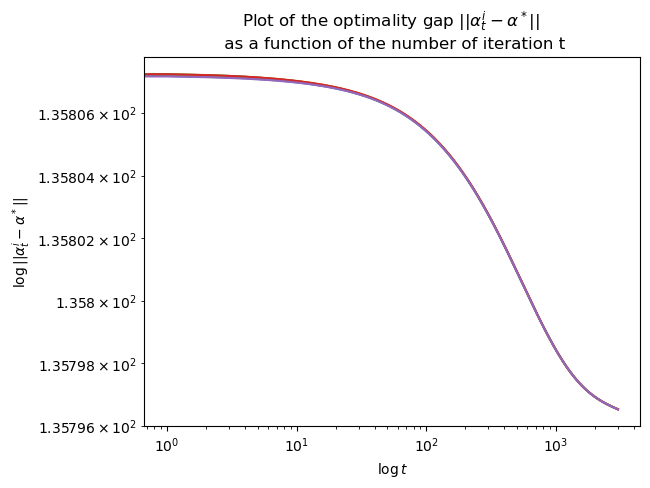

In [28]:
plt.loglog(error)
plt.xlabel("$\\log t$")
plt.ylabel("$\\log \\|\\|\\alpha_t^i - \\alpha^*\\|\\|$")
plt.title("Plot of the optimality gap $\\|\\|\\alpha_t^i - \\alpha^*\\|\\|$ \n as a function of the number of iteration t")

#### Varying the graph structure

In [28]:
W = np.ones((a,a))/a


## Gradient tracking

In [47]:
def gradient_tracking(nb_it,agents,M,W,K,Y,step_size,sigma,alpha_star):
    nb_agents = len(agents) # Number of agents at play
    m = len(M)
    error = np.zeros((nb_it,nb_agents))
    # We start by initializing the alpha at each devices
    #y = np.random.random(size=(nb_agents,m))
    y = np.ones((nb_agents,m))
    
    g_k = y.copy()
    for a in range(nb_agents):
        g_k[a] = nabla_g_a(y[a],a,sigma,Y,K,M,agents)
    
    for k in tqdm(range(nb_it)):
        # We update y
        new_y = y.copy()
        # Mixing and update
        new_y = W@y - step_size*g_k

        # We update g
        #new_g = g_k.copy()
        # Mixing
        new_g = W@g_k
        #Update
        for a in range(nb_agents):
            grad_k_plus_1 = nabla_g_a(new_y[a],a,sigma,Y,K,M,agents)
            grad_k = nabla_g_a(y[a],a,sigma,Y,K,M,agents)
            new_g[a] += grad_k_plus_1 - grad_k
            #new_g[a] = grad_k_plus_1 
        
        y = new_y.copy()
        g_k = new_g.copy()
        error[k] = np.linalg.norm(y - alpha_star,axis=1)
        
    return y, error

In [68]:
nb_it = 10000
K = compute_K(x[:n],x[:n])
step_size = 1/L
res,error = gradient_tracking(nb_it,agents,M,W,K,y[:n],step_size,sigma,true_alpha)

100%|██████████| 10000/10000 [00:07<00:00, 1342.31it/s]


In [69]:
alpha = np.mean(res,axis=0)

In [70]:
alpha

array([-0.14541583,  0.39006778,  0.9289352 ,  0.02677607, -0.12936802,
        0.12015811, -0.69735247,  1.16608751,  0.36614165, -0.68044509])

In [71]:
g(alpha,K,M,y,n,sigma)

52.87289298776739

Text(0.5, 1.0, 'Plot of $f$ using GT to solve the problem \n Error between both = 0.41460808447368913')

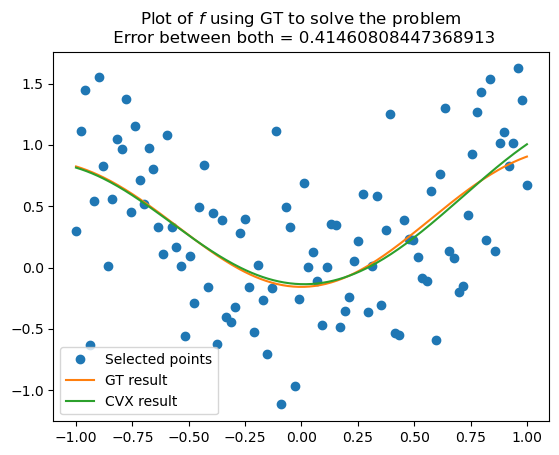

In [72]:
f_approx = plot_f(alpha,x_selected,x_prime)
plt.plot(x[:n],y[:n],'o',label="Selected points")
plt.plot(x_prime,f_approx,label="GT result")
plt.plot(x_prime,f_approx_true_linalg,label="CVX result")
plt.legend()
plt.title("Plot of $f$ using GT to solve the problem \n Error between both = " +str(np.linalg.norm(f_approx-f_approx_true_linalg)))

Text(0.5, 1.0, 'Plot of the optimality gap $\\|\\|\\alpha_t^i - \\alpha^*\\|\\|$ \n as a function of the number of iteration t')

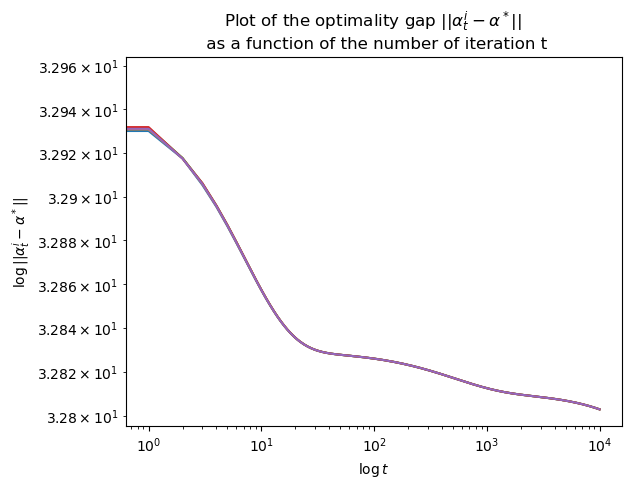

In [35]:
plt.loglog(error)
plt.xlabel("$\\log t$")
plt.ylabel("$\\log \\|\\|\\alpha_t^i - \\alpha^*\\|\\|$")
plt.title("Plot of the optimality gap $\\|\\|\\alpha_t^i - \\alpha^*\\|\\|$ \n as a function of the number of iteration t")

## Dual Decomposition

The first step of the dual decomposition algorithm is the following :
$$\alpha^{a,\star} = \arg \min_{\alpha^a \in \mathbb{R^m}} g_a(\alpha^a) +\sum_{a \sim b}(\lambda^{a,b}_k)^TA_{a,b}\alpha^a$$
We encoutered divergence problem when we tried to solve exactly this problem. In order to fix it, we actually solve a regularized version of the problem. We introduce a regularization parameter $\beta$ and we solve, at each step, the following problem :
$$\alpha^{a,\star} = \arg \min_{\alpha^a \in \mathbb{R^m}} \underbrace{g_a(\alpha^a) + \sum_{a \sim b}(\lambda^{a,b}_k)^TA_{a,b}\alpha^a+ \beta \|\alpha\|^2}_{:=h_a(\alpha) }$$

In our context, we thus have :
$$h_a(\alpha) := \frac{1}{10}\alpha^TK_{mm}\alpha + \frac{1}{2\sigma^2}\sum_{i\in A} \|y_i - K_{(i)m}\alpha\|^2 + \sum_{a \sim b}(\lambda^{a,b}_k)^TA_{a,b}\alpha + \beta \|\alpha\|^2$$
Therefore, we have 
$$\nabla h_a(\alpha) = \frac{1}{5}K_{mm}\alpha - \frac{1}{\sigma^2}\sum_{i\in A} K_{(i)m}^T(y_i - K_{(i)m}\alpha) + \sum_{a \sim b}(\lambda^{a,b}_k)^TA_{a,b} + 2\beta \alpha$$
and we then have $\alpha^{a,\star}$ that satisfies :
$$\left( \frac{1}{5}K_{mm} + \frac{1}{\sigma^2}\sum_{i\in A}K_{(i)m}^TK_{(i)m}+ 2\beta I_m\right)\alpha^{a,\star} = \frac{1}{\sigma^2}\sum_{i\in A}K_{(i)m}^Ty_i -  \sum_{a \sim b}(\lambda^{a,b}_k)^TA_{a,b}$$

In our case, as the constraint $A\alpha = 0$ encodes the edges of the graph $\mathcal{G}$, we can rewrite the first step of the dual decomposition algorithm as :
$$\alpha^{a,\star} = \arg \min_{\alpha^a \in \mathbb{R^m}} g_a(\alpha^a) + \sum_{a \sim b \\ a < b}(\lambda^{a,b}_k)^T\alpha^a - \sum_{a \sim b \\ b < a}(\lambda^{b,a}_k)^T\alpha^a + \beta \|\alpha\|^2$$


In [21]:
def dual_decomposition(nb_it,agents,M,W,K,Y,step_size,sigma,reg_param):
    nb_agents = len(agents)
    m = len(M)
    
    alpha = np.zeros((nb_agents,m))
    lmbda = np.random.random((W.shape[0],W.shape[0],m))
    #lmbda = np.zeros((W.shape[0],W.shape[0],m))
    g_vals = []
    for k in tqdm(range(nb_it)):
        # Find \alpha^{a,\star} s.t. A|alpha^{a,\star} = b
        for a in range(nb_agents):
            # We first compute A
            K_mm = K[M,:][:,M]
    
            somme = np.zeros_like(K_mm)
            for i in agents[a]:
                K_im = K[i,:][M]
                somme += K_im.reshape(m,1)@K_im.reshape(1,m)

            A = K_mm/5  + somme/(sigma**2) + 2*reg_param*np.eye(m)
            
            # Then we compute the second term b
            b_1 = np.zeros_like(alpha[a])
            for i in agents[a]:
                K_im = K[i,:][M]
                b_1 += Y[i]*K_im.T
            b_2 = np.zeros_like(alpha[a])
            # We look for each agent if it is a neighbour of a
            for b in range(nb_agents):
                if (W[a,b] != 0)and(b < a):
                    b_2 += lmbda[a,b]
                elif (W[a,b] != 0)and(a < b):
                    b_2 -= lmbda[b,a]
            alpha[a] = np.linalg.solve(A,b_1/(sigma**2) - b_2)
        
        #Update lambda^{a,b}_{k+1}
        for i in range(nb_agents):
            for j in range(0,i):
                lmbda[i,j] += step_size*(alpha[i] - alpha[j])
                
        g_vals.append(g(np.mean(alpha,axis=0),K,M,Y,n,sigma))
    return alpha, lmbda, g_vals
    
    

In [22]:
nb_it = 100000
reg_param = 0.005
K = compute_K(x[:n],x[:n])
#step_size = coef
step_size = 1/L
alpha_res,lmbda_res,g_val = dual_decomposition(nb_it,agents,M,W,K,y[:n],step_size,sigma,reg_param)

100%|██████████| 100000/100000 [01:09<00:00, 1438.76it/s]


In [23]:
alpha = np.mean(alpha_res,axis=0)

In [24]:
alpha

array([ 0.28317001, -0.39904874,  1.23789612, -0.30026498,  0.71571919,
       -0.56385255,  1.0434117 , -0.38222198, -0.4548215 ,  0.25061748])

In [25]:
g(alpha,K,M,y,n,sigma)

52.70784844361199

Text(0.5, 1.0, 'Plot of $f$ using Dual Decomposition to solve the problem \n Error between both = 0.2802667444274919')

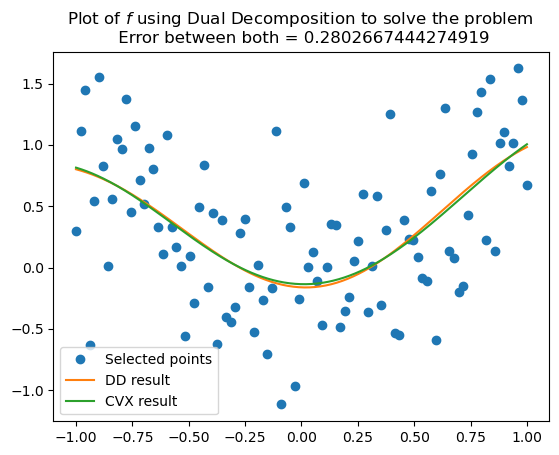

In [26]:
f_approx = plot_f(alpha,x_selected,x_prime)
plt.plot(x[:n],y[:n],'o',label="Selected points")
plt.plot(x_prime,f_approx,label="DD result")
plt.plot(x_prime,f_approx_true_linalg,label="CVX result")
plt.legend()
plt.title("Plot of $f$ using Dual Decomposition to solve the problem \n Error between both = " +str(np.linalg.norm(f_approx-f_approx_true_linalg)))

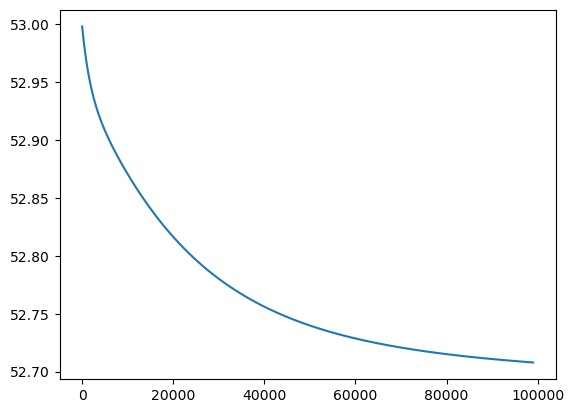

In [27]:
plt.plot(g_val[1000:])

$$\alpha^{a,\star} = \arg \min_{\alpha^a \in \mathbb{R^m}} g_a(\alpha^a) + \sum_{a \sim b \\ a < b}(\lambda^{a,b}_k)^T\alpha^a - \sum_{a \sim b \\ b < a}(\lambda^{b,a}_k)^T\alpha^a$$

In [65]:
def objectif_2(alpha,lmbda,agents,a,W,K,M,reg_param):
    K_mm = K[M,:][:,M]
    nb_agents = len(agents)
    g_a = np.sum([np.linalg.norm(y[i] -  K[i,:][M]@alpha)**2 for i in agents[a]])/(2*sigma**2) + 0.1*alpha.T@K_mm@alpha
    lagrange = 0
    for b in range(nb_agents):
        if (W[a,b] != 0) and(b < a):
            lagrange += lmbda[a,b].T@alpha
        elif (W[a,b] != 0)and(a < b):
            lagrange -= lmbda[b,a].T@alpha
    return g_a + lagrange + reg_param*np.linalg.norm(alpha)**2



In [66]:
def dual_decomposition_minimize(nb_it,agents,M,W,K,Y,step_size,sigma,reg_param):
    nb_agents = len(agents)
    m = len(M)
    
    alpha = np.zeros((nb_agents,m))
    lmbda = np.zeros((W.shape[0],W.shape[0],m))
    
    g_val = []
    for k in tqdm(range(nb_it)):
        # Find \alpha^{a,\star} 
        for a in range(nb_agents):
            alpha_a_star = minimize(objectif_2,x0=np.zeros(m),args=(lmbda,agents,a,W,K,M,reg_param),method='L-BFGS-B')
            alpha[a] = alpha_a_star.x 
        #print(alpha)
        #Update lambda^{a,b}_{k+1}
        for i in range(nb_agents):
            for j in range(0,i):
                lmbda[i,j] += step_size*(alpha[i] - alpha[j])
                #print((alpha[a] - alpha[b]))
        #print(g(np.mean(alpha,axis=0),K,M,y,n,sigma))
        g_val.append(g(np.mean(alpha,axis=0),K,M,Y,n,sigma))
    return alpha, lmbda, g_val
    
    

In [67]:
nb_it = 1000
K = compute_K(x[:n],x[:n])
step_size = 1/L
reg_param = 0.005
alpha_res,lmbda_res, g_val = dual_decomposition_minimize(nb_it,agents,M,W,K,y[:n],step_size,sigma,reg_param)

100%|██████████| 1000/1000 [03:52<00:00,  4.30it/s]


In [68]:
alpha = np.mean(alpha_res,axis=0)
g(alpha,K,M,y,n,sigma)

53.22839591365719

In [69]:
alpha

array([ 0.31190329, -0.3345716 ,  1.53560547, -0.26733018,  0.68488312,
       -0.42705829,  0.9667004 , -0.55735794, -0.62074582,  0.25311946])

In [70]:
np.mean(lmbda_res,axis=0)

array([[ 0.00046871,  0.01481656,  0.08730124,  0.01071945, -0.00439253,
         0.01453058, -0.0075922 , -0.03441314, -0.02006197,  0.02769736],
       [ 0.0205705 , -0.02432034,  0.02626502, -0.0274006 ,  0.0261093 ,
         0.0012728 ,  0.02964162, -0.02609075, -0.00140445,  0.01487628],
       [-0.01073381,  0.04559488, -0.05883862,  0.04674117, -0.01966609,
         0.01796743, -0.02550673,  0.01516085, -0.03119626, -0.05084291],
       [ 0.01512259, -0.00906296, -0.0274842 , -0.00918779,  0.01747525,
         0.00433277,  0.01871162,  0.0146289 ,  0.02263229,  0.00357709],
       [-0.025428  , -0.02702815, -0.02724345, -0.02087224, -0.01952593,
        -0.03810359, -0.01525431,  0.03071413,  0.03003039,  0.00469218]])

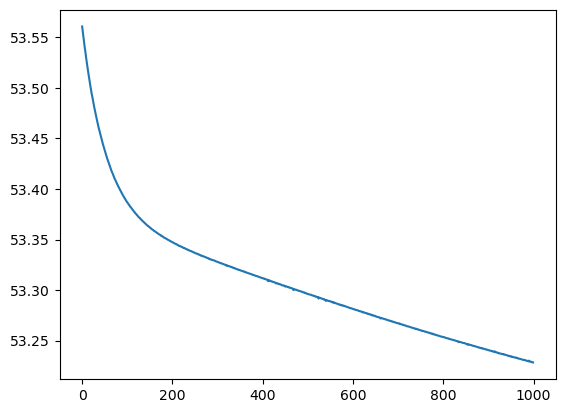

In [71]:
plt.plot(g_val)

Text(0.5, 1.0, 'Plot of $f$ using Dual Decomposition to solve the problem \n Error between both = 0.8372113465307308')

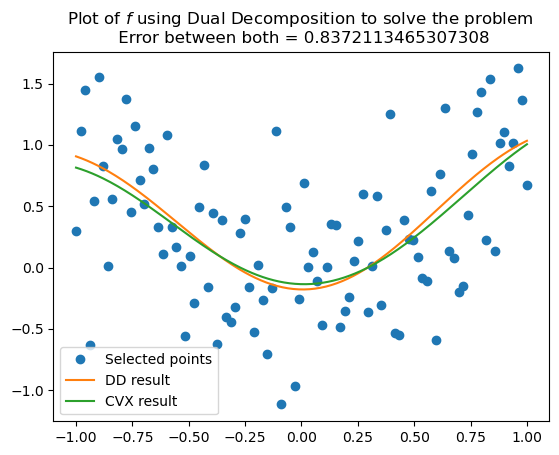

In [72]:
f_approx = plot_f(alpha,x_selected,x_prime)
plt.plot(x[:n],y[:n],'o',label="Selected points")
plt.plot(x_prime,f_approx,label="DD result")
plt.plot(x_prime,f_approx_true_linalg,label="CVX result")
plt.legend()
plt.title("Plot of $f$ using Dual Decomposition to solve the problem \n Error between both = " +str(np.linalg.norm(f_approx-f_approx_true_linalg)))

In [235]:
def compute_A(W):
    A = []
    nb_agents = W.shape[0]
    for a in range(nb_agents):
        for b in range(a+1,nb_agents):
            if W[a,b] != 0: # We have a~b, so we need to add a line to A
                new_line = np.zeros(nb_agents)
                new_line[a] = -1
                new_line[b] = 1
                A.append(new_line)
    return np.array(A)

In [236]:
A = compute_A(W)

In [242]:
u, s, vh = np.linalg.svd(A)

In [244]:
coef = 2*m/(np.max(s)**2)

In [245]:
coef

2.325612413492684e-11

## Alternating Direction Method of Multipliers(ADMM)

In [193]:
def ADMM(nb_it,agents,M,W,K,Y,sigma,beta):
    nb_agents = len(agents)
    m = len(M)
    
    alpha = np.zeros((nb_agents,m))
    y = np.zeros((W.shape[0],W.shape[0],m))
    g_vals = []
    
    for k in tqdm(range(nb_it)):
        # Find \alpha^{a,\star} s.t. A|alpha^{a,\star} = b
        for a in range(nb_agents):
            # We first compute A
            K_mm = K[M,:][:,M]
    
            somme = np.zeros_like(K_mm)
            for i in agents[a]:
                K_im = K[i,:][M]
                somme += K_im.reshape(m,1)@K_im.reshape(1,m)

            A_1 = K_mm/5  + somme/(sigma**2) 
            
            A_2 = np.zeros_like(A_1)
            for b in range(nb_agents):
                if W[a,b] != 0: # Peut-être qu'il faut gerer le cas où a==b
                    A_2 += beta*np.eye(m)
            
            # Then we compute the second term b
            b_1 = np.zeros_like(alpha[a])
            for i in agents[a]:
                K_im = K[i,:][M]
                b_1 += Y[i]*K_im.T
                
            b_2 = np.zeros_like(b_1)
            # We look for each agent if it is a neighbour of a
            for b in range(nb_agents):
                if W[a,b] != 0: # Peut-être qu'il faut gerer le cas où a==b
                    b_2 += beta*y[a,b]
                    
            alpha[a] = np.linalg.solve(A_1+A_2,b_1/(sigma**2) + b_2)
        
        #Update y^{a,b}_{k+1}
        for i in range(nb_agents):
            for j in range(0,nb_agents):
                y[i,j] = (alpha[i]+alpha[j])/2
                
        g_vals.append(g(np.mean(alpha,axis=0),K,M,Y,n,sigma))
    return alpha, y, g_vals
    
    

In [221]:
nb_it = 200000
beta = 100
K = compute_K(x[:n],x[:n])
alpha_res,y_res,g_val = ADMM(nb_it,agents,M,W,K,y[:n],sigma,beta)

100%|██████████| 200000/200000 [02:49<00:00, 1178.31it/s]


In [222]:
alpha = np.mean(alpha_res,axis=0)
g(alpha,K,M,y,n,sigma)

52.61209365853798

In [223]:
alpha

array([-0.14254825, -0.20169334,  1.93748023,  0.28504165,  1.03536706,
       -2.02551497,  1.96135818,  0.10720259, -1.29424597, -0.09161913])

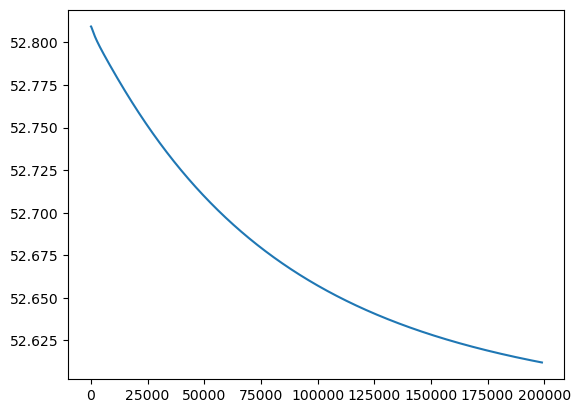

In [224]:
plt.plot(g_val[1000:])